<a href="https://colab.research.google.com/github/dhyeybm/PotholeDetection/blob/master/pothole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [13]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [14]:
!kaggle datasets download -d virenbr11/pothole-and-plain-rode-images

pothole-and-plain-rode-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip pothole-and-plain-rode-images.zip


Archive:  pothole-and-plain-rode-images.zip
replace My Dataset/test/Plain/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import style
import random as rn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
from keras.applications.inception_resnet_v2 import InceptionResNetV2


In [0]:
def make_train_data(label,DIR):
#     print(os.listdir(DIR))
    for img in os.listdir(DIR):
        try:
            path = os.path.join(DIR,img)
            img = Image.open(path).convert("RGB")
            img = img.resize((256,256))
            img = np.array(img)
#             print(img.shape)
            X.append(img)
            Z.append(str(label))
        except IOError:
            pass
        


In [19]:
X=[]
Z=[]
IMG_SIZE=256
Plain='My Dataset/train/Plain'
Pothole='My Dataset/train/Pothole'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)
print(len(X))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


724


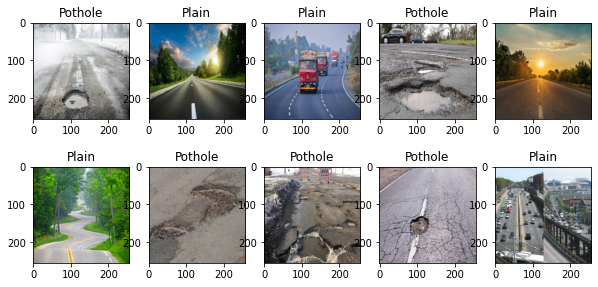

In [20]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [0]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.stack(X)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

In [22]:
base = InceptionResNetV2(include_top = False,weights = 'imagenet',input_shape = (256,256,3),pooling = 'max')
base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [0]:
model = Sequential()
model.add(base)
model.add(Dropout(0.5))
model.add(Dense(2048,activation = 'relu'))
model.add(Dense(2048,activation = 'relu'))
model.add(Dense(1024,activation = 'relu'))
model.add(Dense(2,activation = 'softmax'))



In [24]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [27]:
epochs = 25
batch_size = 64
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.001, patience=2, verbose=1)
base.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.1, horizontal_flip=True)
datagen.fit(x_train)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 63,781,090
Trainable params: 63,720,546
Non-trainable params: 60,544
_____________________________________

In [28]:
History = model.fit_generator(datagen.flow(x_train, y_train,batch_size = 32), epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/25
17/17 [==============================] - 105s 6s/step - loss: 0.7813 - accuracy: 0.5212 - val_loss: 0.5937 - val_accuracy: 0.6740
Epoch 2/25
17/17 [==============================] - 28s 2s/step - loss: 0.5983 - accuracy: 0.6722 - val_loss: 0.4179 - val_accuracy: 0.8122
Epoch 3/25
17/17 [==============================] - 28s 2s/step - loss: 0.5472 - accuracy: 0.7201 - val_loss: 0.3331 - val_accuracy: 0.8453
Epoch 4/25
17/17 [==============================] - 28s 2s/step - loss: 0.4104 - accuracy: 0.8269 - val_loss: 0.4103 - val_accuracy: 0.8232
Epoch 5/25
17/17 [==============================] - 28s 2s/step - loss: 0.3558 - accuracy: 0.8674 - val_loss: 0.2685 - val_accuracy: 0.8950
Epoch 6/25
17/17 [==============================] - 28s 2s/step - loss: 0.3519 - accuracy: 0.8416 - val_loss: 0.1943 - val_accuracy: 0.9392
Epoch 7/25
17/17 [==============================] - 28s 2s/step - loss: 0.2946 - accuracy: 0.8785 - val_loss: 0.1951 - val_accuracy: 0.9337
Epoch 8/25
17/17 [=

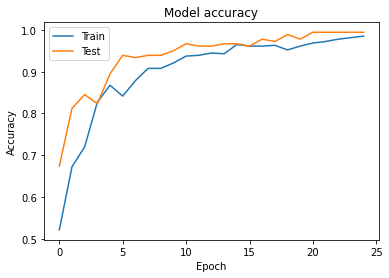

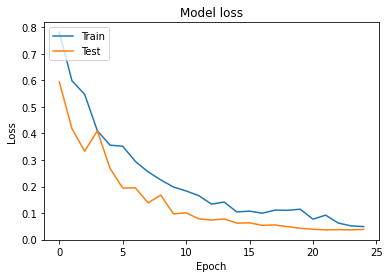

In [29]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [31]:
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.2.0-rc4


In [0]:
!mkdir -p saved_model
model.save('saved_model/my_model')  

In [33]:
load_model = tf.keras.models.load_model('saved_model/my_model')
load_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 63,781,090
Trainable params: 63,720,546
Non-trainable params: 60,544
_____________________________________

In [0]:
def make_test_data(label,DIR):

# print(os.listdir(DIR))
for img in os.listdir(DIR):
    try:
        path = os.path.join(DIR,img)
        img = Image.open(path).convert("RGB")
        img = img.resize((256,256))
        img = np.array(img)
# print(img.shape)
        X.append(img)
        Z.append(str(label))
    except IOError:
        pass

In [35]:
X=[]
Z=[]
IMG_SIZE=256
Plain='My Dataset/test/Plain'
Pothole='My Dataset/test/Pothole'

make_test_data('Plain',Plain)
make_test_data('Pothole',Pothole)
print(len(X))

16


In [36]:
le=LabelEncoder()
Y_test=le.fit_transform(Z)
# Y_test=to_categorical(Y_test,2)
X_test=np.stack(X)
print(X_test.shape)
print(Y_test.shape)

(16, 256, 256, 3)
(16,)


Predicted : Pothole Road
Answer : Plain Road


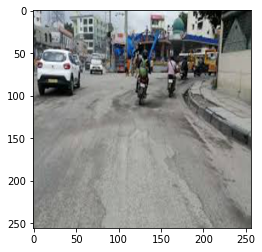

Predicted : Pothole Road
Answer : Plain Road


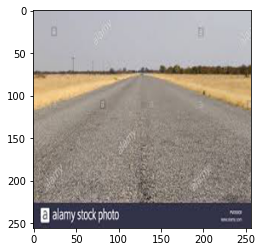

Predicted : Pothole Road
Answer : Plain Road


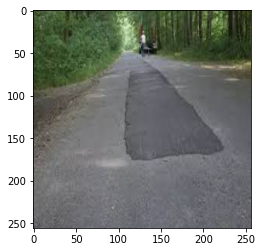

Predicted : Plain Road
Answer : Plain Road


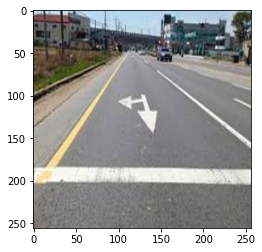

Predicted : Plain Road
Answer : Plain Road


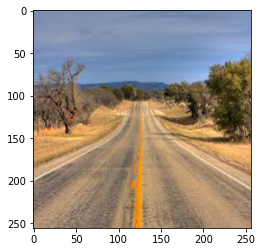

Predicted : Plain Road
Answer : Plain Road


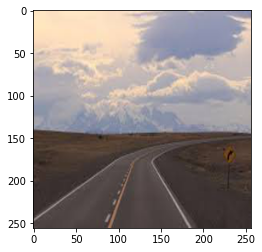

Predicted : Plain Road
Answer : Plain Road


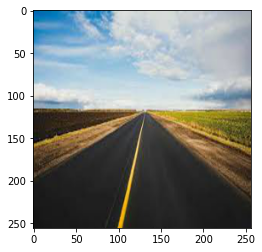

Predicted : Plain Road
Answer : Plain Road


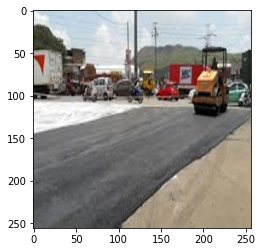

Predicted : Pothole Road
Answer : Pothole Road


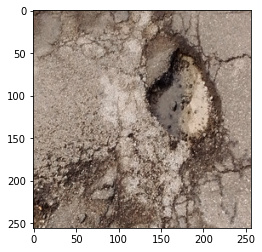

Predicted : Pothole Road
Answer : Pothole Road


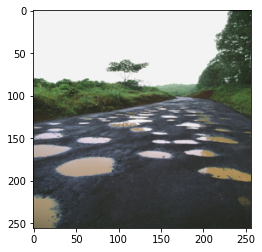

Predicted : Pothole Road
Answer : Pothole Road


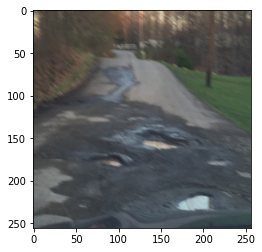

Predicted : Pothole Road
Answer : Pothole Road


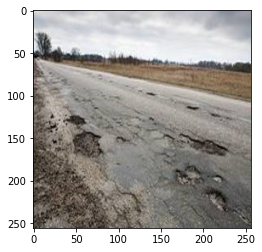

Predicted : Pothole Road
Answer : Pothole Road


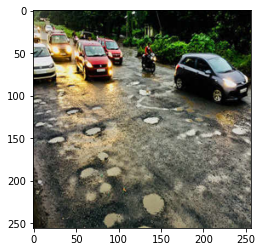

Predicted : Pothole Road
Answer : Pothole Road


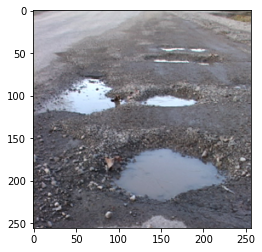

Predicted : Pothole Road
Answer : Pothole Road


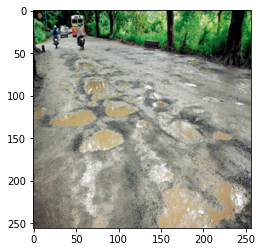

Predicted : Pothole Road
Answer : Pothole Road


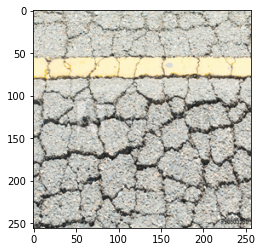

In [48]:
for i in range(16):
  plt.imshow(X_test[i])
  temp = np.expand_dims(X_test[i],axis = 0)
  pred = np.argmax(load_model.predict(temp), axis=-1)
  if(pred[0] == 0):
    print("Predicted : Plain Road")
  else:
    print("Predicted : Pothole Road")
  if(Y_test[i] == 0):
    print("Answer : Plain Road")
  else:
    print("Answer : Pothole Road")
  plt.show()




In [50]:
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset

 94% 183M/194M [00:01<00:00, 120MB/s]
100% 194M/194M [00:01<00:00, 105MB/s]


In [52]:
!unzip pothole-detection-dataset.zip



Archive:  pothole-detection-dataset.zip
  inflating: normal/1.jpg            
  inflating: normal/10.jpg           
  inflating: normal/100.jpg          
  inflating: normal/101.jpg          
  inflating: normal/102.jpg          
  inflating: normal/103.jpg          
  inflating: normal/104.jpg          
  inflating: normal/105.jpg          
  inflating: normal/106.jpg          
  inflating: normal/107.jpg          
  inflating: normal/108.jpg          
  inflating: normal/109.jpg          
  inflating: normal/11.jpg           
  inflating: normal/110.jpg          
  inflating: normal/111.jpg          
  inflating: normal/112.jpg          
  inflating: normal/113.jpg          
  inflating: normal/114.jpg          
  inflating: normal/115.jpg          
  inflating: normal/116.jpg          
  inflating: normal/117.jpg          
  inflating: normal/118.jpg          
  inflating: normal/119.jpg          
  inflating: normal/12.jpg           
  inflating: normal/120.jpg          
  inflatin

In [53]:
X=[]
Z=[]
IMG_SIZE=256
Plain='normal'
Pothole='potholes'

make_test_data('Plain',Plain)
make_test_data('Pothole',Pothole)
print(len(X))

681


In [59]:
le=LabelEncoder()
Y_test=le.fit_transform(Z)
# Y_test=to_categorical(Y_test,2)
X_test=np.stack(X)
print(X_test.shape)
print(Y_test.shape)

(681, 256, 256, 3)
(681,)


In [65]:
pred = load_model.predict_classes(X_test)
print(pred.shape)
print(Y_test.shape)
acc = accuracy_score(Y_test,pred)
print(acc)

(681,)
(681,)
0.9955947136563876
